# Importing libraries

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim import SGD, Adam, lr_scheduler
from copy import deepcopy

# Downloading and loading dataset



In [6]:
train_transform = transforms.Compose([                                      
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

train, val = random_split(train, [45000, 5000], generator = torch.manual_seed(0))

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val, batch_size=64,
                                          shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test, batch_size=64,
                                         shuffle=False, num_workers=2)

classes_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

size_train = len(train)
size_val = len(val)
size_test = len(test)

Files already downloaded and verified
Files already downloaded and verified


# Pretrained Resnet (changing only last layer), finetuning all layers

In [7]:
class ResnetCNN(nn.Module):
    def __init__(self):

        super(ResnetCNN, self).__init__()
        pretrained_model = models.resnet18(pretrained=True)

        self.pretrained_model = nn.Sequential(*list(pretrained_model.children())[:-1])
        in_features = pretrained_model.fc.in_features
        self.dropout = nn.Dropout()
        self.final_layer = nn.Linear(in_features = in_features, out_features = 10)
    
    def forward(self,x):
        x = self.pretrained_model(x)
        x = self.dropout(x.view(-1, self.final_layer.in_features))
        return self.final_layer(x)
    

In [8]:
model = ResnetCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [9]:
best_accuracy = -1
best_model = None
model.train_loss = list()
model.train_accuracy = list()
model.val_accuracy = list()

for epoch in range(2):  

    model.train(True)
    training_loss = 0
    training_correct = 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * inputs.size(0)
        predicted = torch.argmax(outputs.detach(),dim=1)
        training_correct += (predicted == labels).sum().item()
    
    training_loss = training_loss/size_train
    training_accuracy = training_correct*100/size_train
    
    model.train_loss.append(training_loss)
    model.train_accuracy.append(training_accuracy)

    print(f"Epoch {epoch+1}")
    print(f"Training loss: {training_loss}")
    print(f"Training accuracy: {training_accuracy}%")    

    validation_correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs.cuda()).cpu()
            predicted = torch.argmax(outputs.detach(), dim=1)
            validation_correct += (predicted == labels).sum().item()

    val_accuracy = validation_correct*100/size_val
    model.val_accuracy.append(val_accuracy)

    print(f"Validation accuracy: {val_accuracy}%")

    if validation_correct > best_accuracy:
        best_accuracy = validation_correct
        best_model = deepcopy(model.state_dict())

    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda()).cpu()
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == labels).sum().item()

    print(f"Test accuracy: {test_correct*100/size_test}%")

    scheduler.step()
    print('-'*30)

print('Finished Training')

Epoch 1
Training loss: 0.6104563399473826
Training accuracy: 79.25555555555556%
Validation accuracy: 84.2%
Test accuracy: 84.35%
------------------------------
Epoch 2
Training loss: 0.20437041378716628
Training accuracy: 93.34666666666666%
Validation accuracy: 92.56%
Test accuracy: 92.71%
------------------------------
Finished Training


In [10]:
model.load_state_dict(best_model)

test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.cuda()).cpu()
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == labels).sum().item()

print(f"Test accuracy: {test_correct*100/size_test}%")

Test accuracy: 92.71%


# Pretrained Resnet (changing only last layer), finetuning all layers, simple data augmentation

In [ ]:
train_transform = transforms.Compose([                                      
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

train, val = random_split(train, [45000, 5000], generator = torch.manual_seed(0))

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val, batch_size=64,
                                          shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test, batch_size=64,
                                         shuffle=False, num_workers=2)

classes_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

size_train = len(train)
size_val = len(val)
size_test = len(test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class ResnetCNN(nn.Module):
    def __init__(self):

        super(ResnetCNN, self).__init__()
        pretrained_model = models.resnet18(pretrained=True)

        self.pretrained_model = nn.Sequential(*list(pretrained_model.children())[:-1])
        in_features = pretrained_model.fc.in_features
        self.dropout = nn.Dropout()
        self.final_layer = nn.Linear(in_features = in_features, out_features = 10)
    
    def forward(self,x):
        x = self.pretrained_model(x)
        x = self.dropout(x.view(-1, self.final_layer.in_features))
        return self.final_layer(x)

In [ ]:
model = ResnetCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [ ]:
best_accuracy = -1
best_model = None
model.train_loss = list()
model.train_accuracy = list()
model.val_accuracy = list()

for epoch in range(10):  

    model.train(True)
    training_loss = 0
    training_correct = 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * inputs.size(0)
        predicted = torch.argmax(outputs.detach(),dim=1)
        training_correct += (predicted == labels).sum().item()
    
    training_loss = training_loss/size_train
    training_accuracy = training_correct*100/size_train
    
    model.train_loss.append(training_loss)
    model.train_accuracy.append(training_accuracy)

    print(f"Epoch {epoch+1}")
    print(f"Training loss: {training_loss}")
    print(f"Training accuracy: {training_accuracy}%")    

    validation_correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs.cuda()).cpu()
            predicted = torch.argmax(outputs.detach(), dim=1)
            validation_correct += (predicted == labels).sum().item()

    val_accuracy = validation_correct*100/size_val
    model.val_accuracy.append(val_accuracy)

    print(f"Validation accuracy: {val_accuracy}%")

    if validation_correct > best_accuracy:
        best_accuracy = validation_correct
        best_model = deepcopy(model.state_dict())

    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda()).cpu()
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == labels).sum().item()

    print(f"Test accuracy: {test_correct*100/size_test}%")

    scheduler.step()
    print('-'*30)

print('Finished Training')

Epoch 1
Training loss: 0.6427051045099894
Training accuracy: 78.3%
Validation accuracy: 82.2%
Test accuracy: 81.56%
------------------------------
Epoch 2
Training loss: 0.25763239153756035
Training accuracy: 91.42666666666666%
Validation accuracy: 91.66%
Test accuracy: 91.13%
------------------------------
Epoch 3
Training loss: 0.17460074328316583
Training accuracy: 94.38222222222223%
Validation accuracy: 91.84%
Test accuracy: 91.62%
------------------------------
Epoch 4
Training loss: 0.16187369538148244
Training accuracy: 94.84%
Validation accuracy: 91.72%
Test accuracy: 91.67%
------------------------------
Epoch 5
Training loss: 0.16086355093452664
Training accuracy: 94.88%
Validation accuracy: 92.4%
Test accuracy: 91.67%
------------------------------
Epoch 6
Training loss: 0.1606909229464001
Training accuracy: 94.7688888888889%
Validation accuracy: 92.2%
Test accuracy: 91.64%
------------------------------
Epoch 7
Training loss: 0.1617557296925121
Training accuracy: 94.8377777

In [ ]:
model.load_state_dict(best_model)

test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.cuda()).cpu()
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == labels).sum().item()

print(f"Test accuracy: {test_correct*100/size_test}%")

Test accuracy: 91.67%


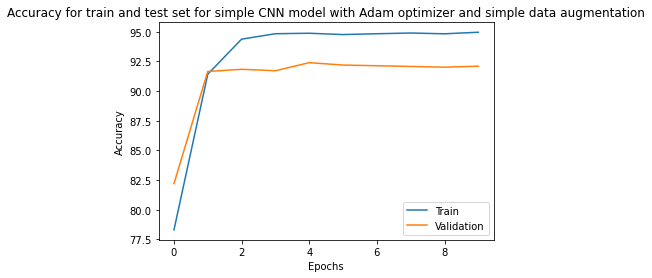

In [ ]:
plt.figure()
plt.plot([i for i in range(10)], model.train_accuracy)
plt.plot([i for i in range(10)], model.val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy for train and test set for simple CNN model with Adam optimizer and simple data augmentation')
plt.show()

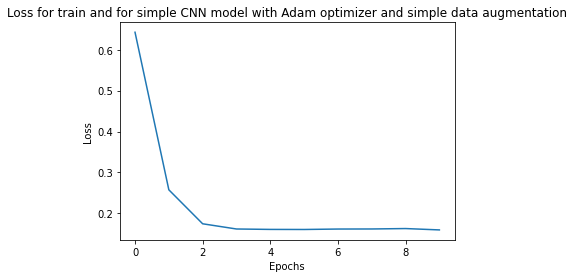

In [ ]:
plt.figure()
plt.plot([i for i in range(10)], model.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for train and for simple CNN model with Adam optimizer and simple data augmentation')
plt.show()

# Pretrained Resnet (changing fc layer, tuning fc and layer4) 

In [ ]:
class ResnetCNN(nn.Module):
    def __init__(self):

        super(ResnetCNN, self).__init__()
        self.pretrained_model = models.resnet18(pretrained=True)

        for param in self.pretrained_model.parameters():
            param.requires_grad = False

        for param in self.pretrained_model.layer4.parameters():
            param.requires_grad = True

        self.pretrained_model.fc = nn.Linear(512, 10)
    
    def forward(self,x):
        x = self.pretrained_model(x)
        return x

model = ResnetCNN().cuda()


In [ ]:
train_transform = transforms.Compose([                                      
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

train, val = random_split(train, [45000, 5000], generator = torch.manual_seed(0))

train_loader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val, batch_size=64,
                                          shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test, batch_size=64,
                                         shuffle=False, num_workers=2)

classes_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

size_train = len(train)
size_val = len(val)
size_test = len(test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = ResnetCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.pretrained_model.parameters()), lr = 0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
best_accuracy = -1
best_model = None
model.train_loss = list()
model.train_accuracy = list()
model.val_accuracy = list()

for epoch in range(10):  

    model.train(True)
    training_loss = 0
    training_correct = 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item() * inputs.size(0)
        predicted = torch.argmax(outputs.detach(),dim=1)
        training_correct += (predicted == labels).sum().item()
    
    training_loss = training_loss/size_train
    training_accuracy = training_correct*100/size_train
    
    model.train_loss.append(training_loss)
    model.train_accuracy.append(training_accuracy)

    print(f"Epoch {epoch+1}")
    print(f"Training loss: {training_loss}")
    print(f"Training accuracy: {training_accuracy}%")    

    validation_correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs.cuda()).cpu()
            predicted = torch.argmax(outputs.detach(), dim=1)
            validation_correct += (predicted == labels).sum().item()

    val_accuracy = validation_correct*100/size_val
    model.val_accuracy.append(val_accuracy)

    print(f"Validation accuracy: {val_accuracy}%")

    if validation_correct > best_accuracy:
        best_accuracy = validation_correct
        best_model = deepcopy(model.state_dict())

    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda()).cpu()
            predicted = torch.argmax(outputs, dim=1)
            test_correct += (predicted == labels).sum().item()

    print(f"Test accuracy: {test_correct*100/size_test}%")

    scheduler.step()
    print('-'*30)

print('Finished Training')

Epoch 1
Training loss: 0.6563594793637594
Training accuracy: 78.38%
Validation accuracy: 85.8%
Test accuracy: 85.22%
------------------------------
Epoch 2
Training loss: 0.3427034184926086
Training accuracy: 88.43777777777778%
Validation accuracy: 86.12%
Test accuracy: 85.61%
------------------------------
Epoch 3
Training loss: 0.21862452816168468
Training accuracy: 92.56444444444445%
Validation accuracy: 85.7%
Test accuracy: 85.75%
------------------------------
Epoch 4
Training loss: 0.08444217401515795
Training accuracy: 97.15333333333334%
Validation accuracy: 90.56%
Test accuracy: 90.32%
------------------------------
Epoch 5
Training loss: 0.03409126376344745
Training accuracy: 98.99555555555555%
Validation accuracy: 90.66%
Test accuracy: 90.3%
------------------------------
Epoch 6
Training loss: 0.010936034187962327
Training accuracy: 99.75333333333333%
Validation accuracy: 90.7%
Test accuracy: 90.01%
------------------------------
Epoch 7
Training loss: 0.002978268820918068
T

In [ ]:
model.load_state_dict(best_model)

test_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.cuda()).cpu()
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == labels).sum().item()

print(f"Test accuracy: {test_correct*100/size_test}%")

Test accuracy: 90.09%


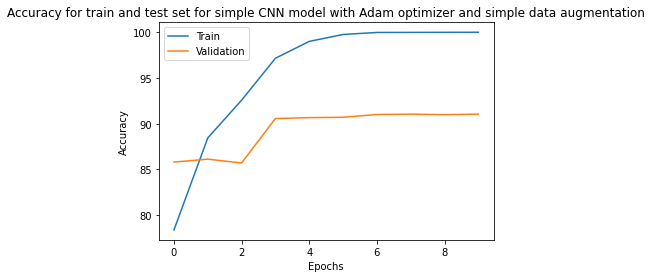

In [ ]:
plt.figure()
plt.plot([i for i in range(10)], model.train_accuracy)
plt.plot([i for i in range(10)], model.val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy for train and test set for simple CNN model with Adam optimizer and simple data augmentation')
plt.show()

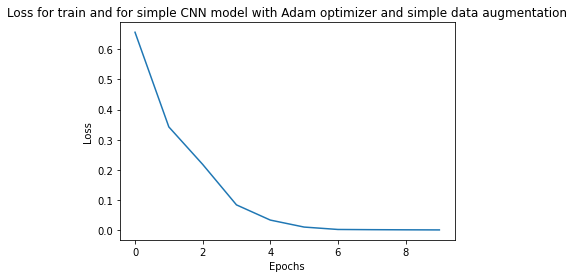

In [ ]:
plt.figure()
plt.plot([i for i in range(10)], model.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for train and for simple CNN model with Adam optimizer and simple data augmentation')
plt.show()